In [29]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

### Data Cleaning

In [ ]:
# load data
trn_data = pd.read_csv("train_data.csv")
test_data  = pd.read_csv("test_data.csv")


In [339]:
# change event type to int. 1 for race, 0 for sprint.
trn_data["Event_Type"] = (trn_data["Event_Type"] == "Race").astype(int)
test_data["Event_Type"] = (test_data["Event_Type"] == "Race").astype(int)

In [340]:
# clean NaNs
cols_to_fill = ["Sprint_Qual_Position", "Sprint_Race_Position","Sector1Time", "Sector2Time", "Sector3Time", "SpeedST", "Stint", "Race_Position"]
trn_data[cols_to_fill] = trn_data[cols_to_fill].fillna(-1)

test_data[cols_to_fill] = test_data[cols_to_fill].fillna(-1)

# have to think if this is the right way to do this



In [341]:
def check_teams():
    unique_teams_pre_2025 = trn_data["TeamName"].unique()
    unique_teams_pre_2025.sort()
    unique_teams_2025 = test_data["TeamName"].unique()
    unique_teams_2025.sort()
    print(unique_teams_pre_2025)
    print(unique_teams_2025)

    teams_2025 = set(unique_teams_2025)
    unknown_teams = []
    for team in unique_teams_pre_2025: 
        if team not in teams_2025:
            unknown_teams.append(team)
    print(f"Unknown Teams: {unknown_teams}")

check_teams()

['Alfa Romeo' 'AlphaTauri' 'Alpine' 'Aston Martin' 'Ferrari'
 'Haas F1 Team' 'Kick Sauber' 'McLaren' 'Mercedes' 'RB' 'Red Bull Racing'
 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: ['Alfa Romeo', 'AlphaTauri', 'RB']


In [342]:
# edit pre 2025 teams to match 2025 teams. 
# alphatauri == RB == Racing Bulls
# alfa romeo == kick sauber

trn_data.loc[(trn_data["TeamName"] == "AlphaTauri") | (trn_data["TeamName"] == "RB"), "TeamName"] = "Racing Bulls"
trn_data.loc[(trn_data["TeamName"] == "Alfa Romeo"), "TeamName"] = "Kick Sauber"
check_teams()


['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: []


In [343]:
unique_teams = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_teams = unique_teams["TeamName"].unique()
len(unique_teams)

10

In [344]:
unique_teams

array(['Red Bull Racing', 'Racing Bulls', 'Alpine', 'Ferrari',
       'Aston Martin', 'Haas F1 Team', 'Williams', 'Kick Sauber',
       'McLaren', 'Mercedes'], dtype=object)

In [345]:
def get_all_drivers():
    all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
    all_drivers = all_drivers.groupby("DriverNumber")["BroadcastName"].unique().apply(list).to_dict()
    return all_drivers

# issues found here: 1) driver number not unqiue (e.g. two diff drivers can share the same driver number in history) 2) one driver can have multiple driver numbers through history.
# Soln: need to create a bijection. By taking all the unique driver names and creating your own mapping or just one hot encoding? 

In [346]:
# code to get rid of nan values for driver broadcast name
all_drivers = get_all_drivers()
trn_data.iloc[35,1] = all_drivers[trn_data.iloc[35,0]][0]
trn_data.iloc[725,1] = all_drivers[trn_data.iloc[725,0]][0]

# fix 'A ANTONELLI', 'K ANTONELLI'
test_data.iloc[2,1] = 'K ANTONELLI'

In [347]:
trn_data[trn_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [348]:
test_data[test_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [349]:
test_data.loc[test_data["DriverNumber"]==12,:]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position
2,12,K ANTONELLI,Mercedes,1,Australia,Melbourne,2025,1,-1.0,-1.0,16.0,36.392589,23.503333,47.519421,255.947368,6.0,4.0
22,12,K ANTONELLI,Mercedes,2,China,Shanghai,2025,0,7.0,7.0,8.0,26.524509,29.694607,42.096607,319.732143,2.0,6.0
42,12,K ANTONELLI,Mercedes,3,Japan,Suzuka,2025,1,-1.0,-1.0,6.0,32.952885,42.184377,18.081623,298.924528,2.0,6.0
62,12,K ANTONELLI,Mercedes,4,Bahrain,Sakhir,2025,1,-1.0,-1.0,4.0,32.644768,43.987333,24.861965,308.678571,4.0,11.0
82,12,K ANTONELLI,Mercedes,5,Saudi Arabia,Jeddah,2025,1,-1.0,-1.0,5.0,36.267633,30.152100,31.564760,304.000000,2.0,6.0


In [350]:
# issue 1 with driver numbers

drivers = get_all_drivers()
for key in drivers:
    if len(drivers[key]) > 1: print(f"{key}:{drivers[key]}")


5:['S VETTEL', 'G BORTOLETO']
6:['N LATIFI', 'I HADJAR']


In [351]:
# issue 2 with driver numbers 

arr_from_drivers = []
for key in drivers: 
    for driver in drivers[key]: 
        arr_from_drivers.append(driver)

arr_from_drivers.sort()

from collections import Counter
counts = Counter(arr_from_drivers)

# Filter duplicates
duplicates = {item: count for item, count in counts.items() if count > 1}

print(duplicates)

{'J DOOHAN': 2, 'L LAWSON': 2, 'N DE VRIES': 2, 'O BEARMAN': 3}


In [352]:
all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_driver_names = all_drivers["BroadcastName"].unique()
unique_driver_names.sort()
len(unique_driver_names)


31

In [353]:
unique_driver_names

array(['A ALBON', 'C LECLERC', 'C SAINZ', 'D RICCIARDO', 'E OCON',
       'F ALONSO', 'F COLAPINTO', 'G BORTOLETO', 'G RUSSELL', 'G ZHOU',
       'I HADJAR', 'J DOOHAN', 'K ANTONELLI', 'K MAGNUSSEN', 'L HAMILTON',
       'L LAWSON', 'L NORRIS', 'L SARGEANT', 'L STROLL', 'M SCHUMACHER',
       'M VERSTAPPEN', 'N DE VRIES', 'N HULKENBERG', 'N LATIFI',
       'O BEARMAN', 'O PIASTRI', 'P GASLY', 'S PEREZ', 'S VETTEL',
       'V BOTTAS', 'Y TSUNODA'], dtype=object)

In [354]:
unique_locations = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_locations = unique_locations["Location"].unique()
len(unique_locations)

25

In [355]:
unique_locations

array(['Sakhir', 'Jeddah', 'Melbourne', 'Imola', 'Miami', 'Barcelona',
       'Monaco', 'Baku', 'Montréal', 'Silverstone', 'Spielberg',
       'Le Castellet', 'Budapest', 'Spa-Francorchamps', 'Zandvoort',
       'Monza', 'Marina Bay', 'Suzuka', 'Austin', 'Mexico City',
       'São Paulo', 'Yas Island', 'Lusail', 'Las Vegas', 'Shanghai'],
      dtype=object)

In [356]:
trn_data = trn_data.drop(columns=["DriverNumber","Round_Number","Country"])
test_data = test_data.drop(columns=["DriverNumber","Round_Number","Country"])

In [357]:
# just for now until you can one hot encode better:
trn_data = trn_data.drop(columns=["BroadcastName"])
test_data = test_data.drop(columns=["BroadcastName"])

In [358]:
# one hot encode: driver, team, circuit, year

#df_encoded = pd.get_dummies(df, columns=["YourColumnName"])
trn_data = pd.get_dummies(trn_data,columns=['TeamName'], drop_first=True)
trn_data = pd.get_dummies(trn_data,columns=['Location'], drop_first=True)
trn_data = pd.get_dummies(trn_data,columns=['Year'], drop_first=True)

In [359]:
trn_data

,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position,...,Location_Shanghai,Location_Silverstone,Location_Spa-Francorchamps,Location_Spielberg,Location_Suzuka,Location_São Paulo,Location_Yas Island,Location_Zandvoort,Year_2023,Year_2024
0,1,-1.0,-1.0,2.0,33.720943,44.042333,25.901444,278.895833,4.0,19.0,...,0,0,0,0,0,0,0,0,0,0
1,1,-1.0,-1.0,10.0,32.808465,43.315864,24.596659,291.687500,3.0,20.0,...,0,0,0,0,0,0,0,0,0,0
2,1,-1.0,-1.0,4.0,33.359873,44.062893,25.503964,282.716981,4.0,18.0,...,0,0,0,0,0,0,0,0,0,0
3,1,-1.0,-1.0,8.0,33.591357,44.109825,25.341860,284.638298,4.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,1,-1.0,-1.0,1.0,33.484018,43.873719,25.345807,277.478261,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1,-1.0,-1.0,3.0,18.369789,38.366034,32.846759,307.551724,2.0,2.0,...,0,0,0,0,0,0,1,0,0,1
1355,1,-1.0,-1.0,20.0,18.409214,39.289000,33.761982,303.508772,2.0,15.0,...,0,0,0,0,0,0,1,0,0,1
1356,1,-1.0,-1.0,7.0,18.254684,38.713121,33.139845,305.844828,2.0,5.0,...,0,0,0,0,0,0,1,0,0,1
1357,1,-1.0,-1.0,9.0,19.660966,40.312667,34.803767,300.166667,2.0,18.0,...,0,0,0,0,0,0,1,0,0,1


### Data Exploration

In [143]:
trn_data.loc[:,["DriverNumber","BroadcastName"]].iloc[0:20,:]

,DriverNumber,BroadcastName
0,1,M VERSTAPPEN
1,10,P GASLY
2,11,S PEREZ
3,14,F ALONSO
4,16,C LECLERC
5,18,L STROLL
6,20,K MAGNUSSEN
7,22,Y TSUNODA
8,23,A ALBON
9,24,G ZHOU


In [144]:
def plt_race_positions(driverNumbers):
    df = pd.DataFrame()
    plt.figure(figsize=(20,10))
    colors = ["red","blue","green"]
    color_idx = 0
    for driver in driverNumbers:
        y = trn_data.loc[trn_data["DriverNumber"]==driver,["Race_Position"]]
        name = trn_data.loc[trn_data["DriverNumber"]==driver,["BroadcastName"]].iloc[0,0]
        x = [i for i in range(1,len(y)+1,1)]
        plt.scatter(x,y,color=colors[color_idx],label=name)
        color_idx+=1
    
    plt.legend()
    plt.show()

        

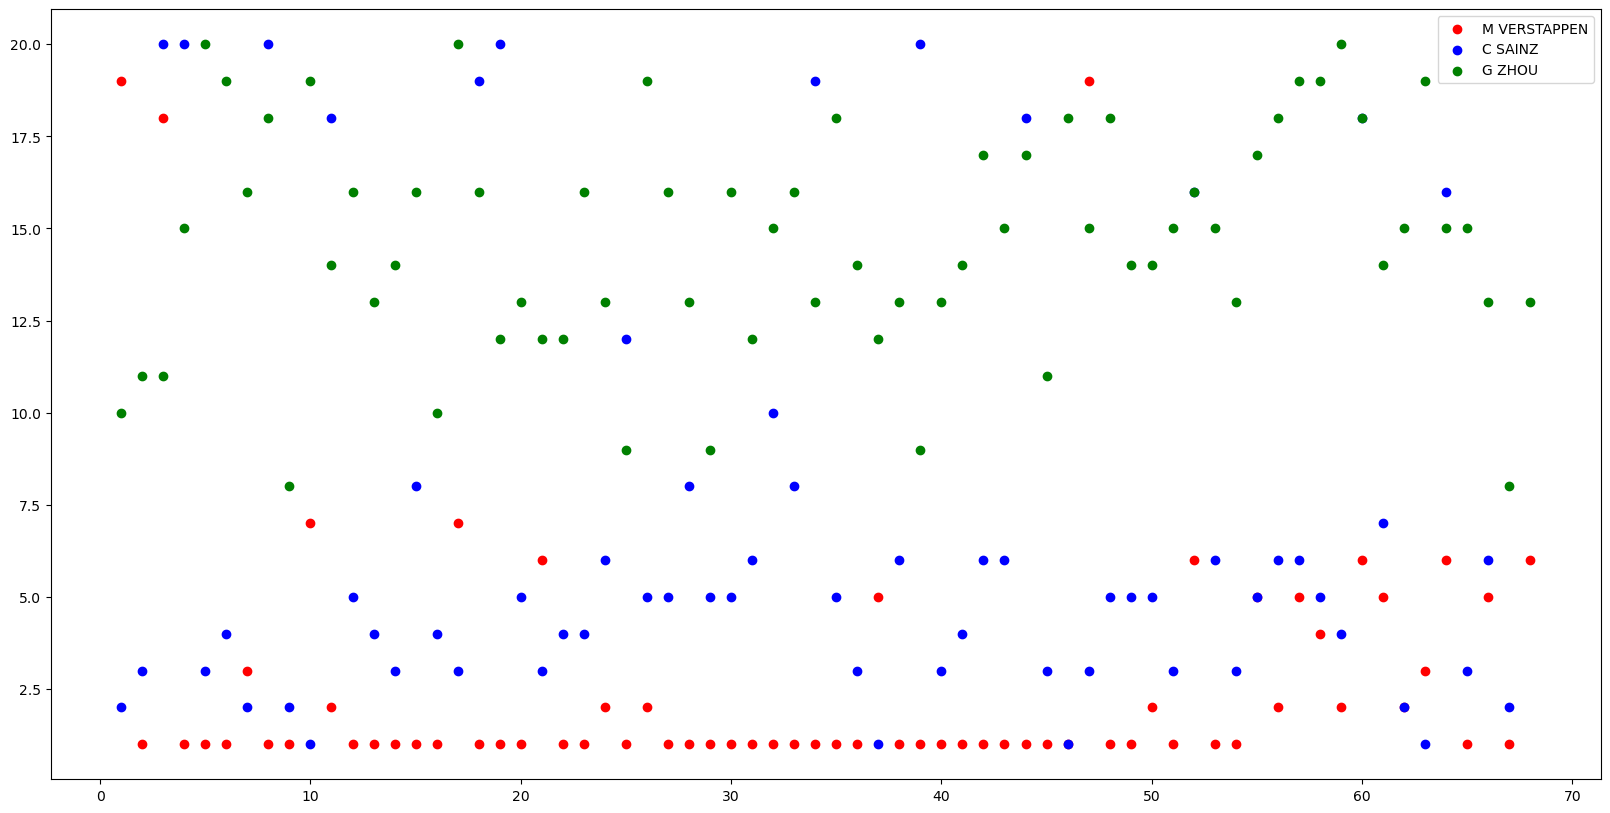

In [145]:
plt_race_positions([1,55,24])

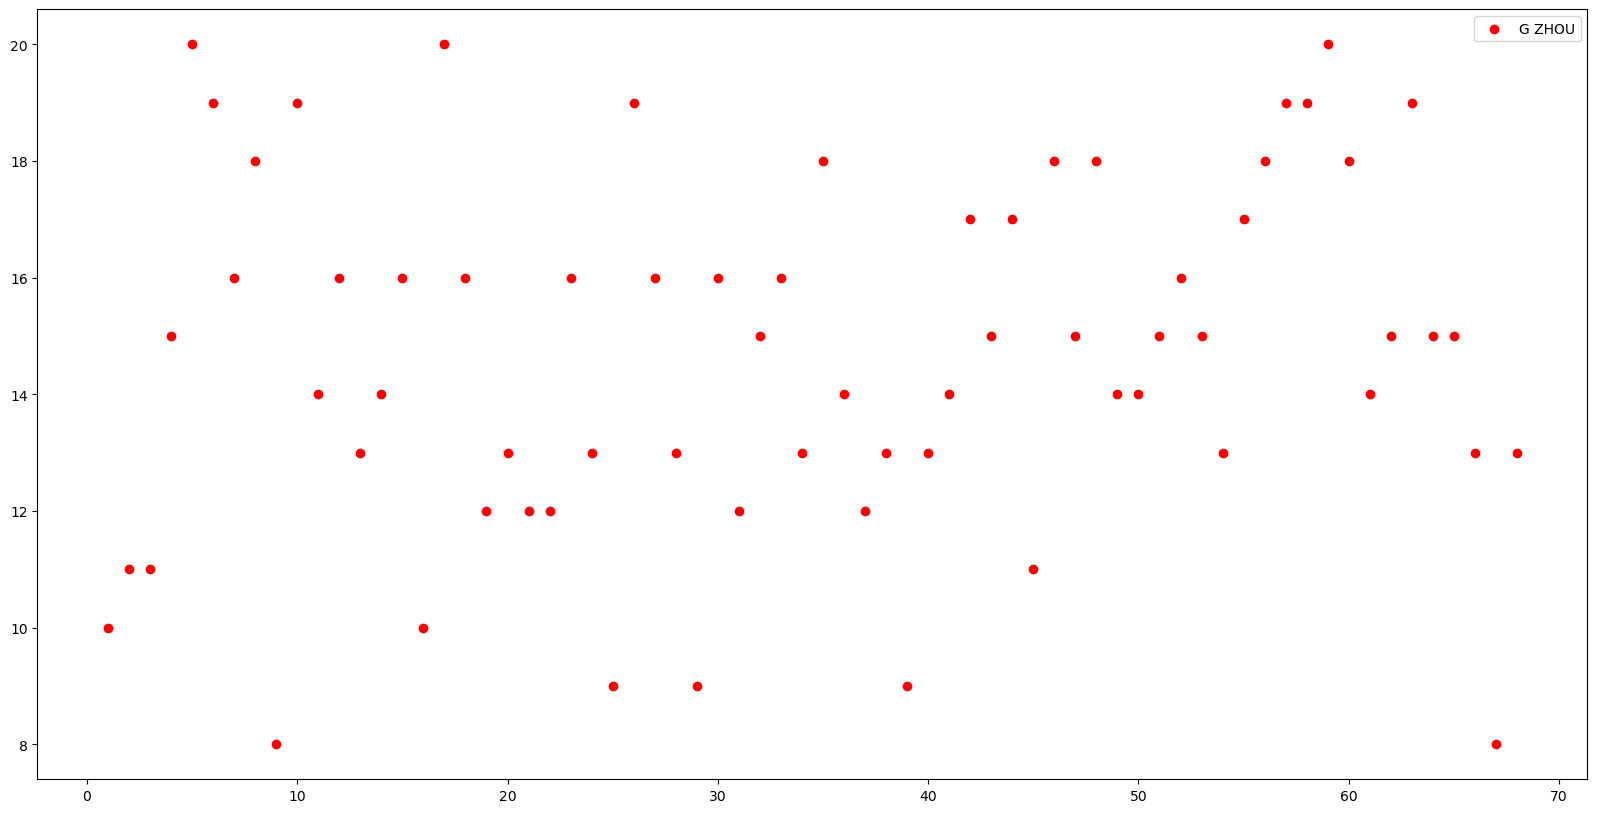

In [146]:
plt_race_positions([24])

### Feature Engineering

come up with equaton for pos gained. shouldbn't penalize thos in top 5 that gain very few because they stayed in the top 5. need to balance that.

create lagged features (maybe with exponential weighting?)

create mean average data for rookies in 2025

In [ ]:
# to encode drivers properly. Based on data, sort drivers into 3 buckest: top-tier, mid-tear, bottom-tier, rookie then one hot encode based on these categories. 
"""
driver_stats = (
    df.groupby('BroadcastName')['Race_Position']
      .agg(['mean','count'])
      .rename(columns={'mean':'avg_pos','count':'n_races'})
      .reset_index()
)
"""


### Training

In [147]:
# split train and val
data = trn_data
trn_data = data.loc[(data["Year"]<=2024) & (data["Round_Number"]<=12),:]
val_data = data.loc[(data["Year"]==2024) & (data["Round_Number"]>12),:]

In [148]:
# Drop cols not meant for training
cols_to_drop = ["BroadcastName","Country","Round_Number"]
trn_data = trn_data.drop(columns=cols_to_drop, axis=1)
val_data = val_data.drop(columns=cols_to_drop, axis=1)
test_data = test_data.drop(columns=cols_to_drop, axis=1)

In [149]:
# split features and target for each dataset 
y_trn = trn_data["Race_Position"]
x_trn = trn_data.drop(columns=["Race_Position"])

y_val = val_data["Race_Position"]
x_val = val_data.drop(columns=["Race_Position"])

y_test = test_data["Race_Position"]
x_test = test_data.drop(columns=["Race_Position"])

In [150]:
# Confirm shapes of data
print(x_trn.shape,y_trn.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape, y_test.shape)

(719, 13) (719,)
(240, 13) (240,)
(100, 13) (100,)


In [153]:
x_trn

,DriverNumber,TeamName,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint
0,1,Red Bull Racing,Sakhir,2022,1,-1.0,-1.0,2.0,33.720943,44.042333,25.901444,278.895833,4.0
1,10,AlphaTauri,Sakhir,2022,1,-1.0,-1.0,10.0,32.808465,43.315864,24.596659,291.687500,3.0
2,11,Red Bull Racing,Sakhir,2022,1,-1.0,-1.0,4.0,33.359873,44.062893,25.503964,282.716981,4.0
3,14,Alpine,Sakhir,2022,1,-1.0,-1.0,8.0,33.591357,44.109825,25.341860,284.638298,4.0
4,16,Ferrari,Sakhir,2022,1,-1.0,-1.0,1.0,33.484018,43.873719,25.345807,277.478261,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,44,Mercedes,Silverstone,2024,1,-1.0,-1.0,2.0,31.042216,38.106731,25.952096,299.903846,3.0
1115,55,Ferrari,Silverstone,2024,1,-1.0,-1.0,7.0,31.464020,38.433923,26.099519,300.230769,4.0
1116,63,Mercedes,Silverstone,2024,1,-1.0,-1.0,1.0,31.117469,38.434636,26.516333,297.393939,2.0
1117,77,Kick Sauber,Silverstone,2024,1,-1.0,-1.0,16.0,31.601660,39.424647,26.683608,292.823529,3.0


In [152]:
y_trn

0       19.0
1       20.0
2       18.0
3        9.0
4        1.0
        ... 
1114     1.0
1115     5.0
1116    19.0
1117    15.0
1118     4.0
Name: Race_Position, Length: 719, dtype: float64